# Previsão da qualidade de vinhos

Este notebook visa explorar o dataset de vinhos para compreender como cada característica dos mesmos impactam em sua qualidade. Além disso, a qualidade do vinho será prevista a partir de tais características. Para isso, usaremos técnicas de aprendizado supervisionado. Este documento é dividido da seguinte forma:

* Análise exploratória dos dados
* Implementação e análise do modelo
* Conclusões
* Referências 

As linhas de código abaixo apenas carregam o dataset em memória e definem algumas funções úteis para esse projeto. Faremos um pequeno ajuste no nome das colunas para que sigam o padrão _snake_case_ e _lower case_ (padrão "pythônico").

In [53]:
import pandas as pd
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
import re
import seaborn as sns

from scipy.stats import chi2_contingency
from __future__ import division

def slugify(c):
    # make strnig lower case
    c = c.lower()
    # remove unused white spaces
    c = c.strip()
    # replace multiple spaces with one
    c = re.sub('\s+', ' ', c)
    # replace spaces with underscore
    c = c.replace(" ", "_")
    return(c)

df = pd.read_csv("data/winequality.csv", sep=";")

rename_dict = {}
for c in df.columns:
    old_c = c
    new_c = slugify(c)
    rename_dict[old_c] = new_c
    
df = df.rename(columns=rename_dict)

In [2]:
df.dtypes

type                     object
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
ph                      float64
sulphates               float64
alcohol                  object
quality                   int64
dtype: object

## Análise exploratória dos dados

Nesta seção exploraremos as características básicas do dataset, não apenas suas dimensões mas também as suas variáveis. O dataset contém 6497 linhas e 13 colunas nas quais cada linha representa um vinho diferente com suas características e apresenta as seguintes colunas:

* `type`: tipo do vinho (categórica)
* `fixed acidity`: acidez fixa (numérica)
* `volatile_acitidy`: acidez volátil (numérica)
* `citric_acid`: quantidade de ácido cítrico (numérica)
* `residual_sugar`: quantidade de açúcar residual (numérica)
* `chlorides`: quantidade de cloretos (numérica)
* `free_sulfur_dioxide`: quantidade de dióxido sulfúrico livre (numérica)
* `total_sulfur_dioxide`: quantidade total de dióxido sulfúrico (numérica)
* `density`: densidade do vinho (numérica)
* `ph`: potencial de hidrogênio do vinho, ou seja, o quanto ele é ácido ou básico (numérica)
* `sulphates`: quantiadde de sulfato no vinho (numérica)
* `alcohol`: quantidade de álcool no vinho (numérica)
* `quality`: qualidade do vinho (categórica)

O código abaixo apresenta uma amostra dos dados sobre vinhos. É perceptível também a partir do código abaixo que todas as variáveis são 100% preenchidas com algum valor. Porém, é preciso de atentar a variável `alcohol` foi identificada pelo Pandas como `object` mas aparentemente ela deveria ser do tipo `float64` (numérica); investigaremos nas próximas seções por que isso deve estar acontencendo. 

In [3]:
df.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
def calculate_density(df):
    sparsity_dict = {}
    for col in df.columns:
        sparsity_dict[col] = df[col].count()/df.shape[0]
    return(sparsity_dict)

density_dict = calculate_density(df)
sorted_density_list = sorted(density_dict.items(), key=lambda x: x[1])

print("\n")
for l in sorted_density_list:
    print("{:25} => Density of {:4.2f}%".format(l[0], l[1]*100))



alcohol                   => Density of 100.00%
chlorides                 => Density of 100.00%
density                   => Density of 100.00%
quality                   => Density of 100.00%
sulphates                 => Density of 100.00%
fixed_acidity             => Density of 100.00%
free_sulfur_dioxide       => Density of 100.00%
residual_sugar            => Density of 100.00%
volatile_acidity          => Density of 100.00%
ph                        => Density of 100.00%
total_sulfur_dioxide      => Density of 100.00%
type                      => Density of 100.00%
citric_acid               => Density of 100.00%


### Explorando variável target: quality

A descrição do desafio informa que a variável `quality` pode receber valores inteiros que variam entre 0 e 10. Porém, como pode ser visto no gráfico abaixo, **não existem exemplos** no dataset de vinhos com qualidade entre 0 e 2 e nem com qualidade 10. Além disso, a distribuição dos valores de qualidade não é uniforme, havendo uma concentração de vinhos com qualidade 5, 6 e 6 (vinhos de certa forma medianos) e uma quantidade significativamente menor de vinhos de baixa qualidade e alta qualidade. Essas observações trazem as consequências abaixo para o modelo de aprendizado supervisionado:

* **Não será possível** prever qualidades 0, 1, 2 e 10, pois o modelo aprende a partir dos exemplos existentes
* Para garantir que as demais classes sejam previstas pelo modelo, teremos de usar uma **estratégia de segmentação estratificada** quando da quebra em treino e teste (será implementado nas próximas seções do estudo)
* O desafio não traz nenhuma informação extra sobre essa distribuição de qualidade dos vinhos. Dessa forma, **consideraremos que, de maneira geral, a qualidade dos vinhos segue uma distribuição normal** (ou seja, existe uma quantidade grande de vinhos medianos e alguns poucos que são muito bons ou muito ruins)

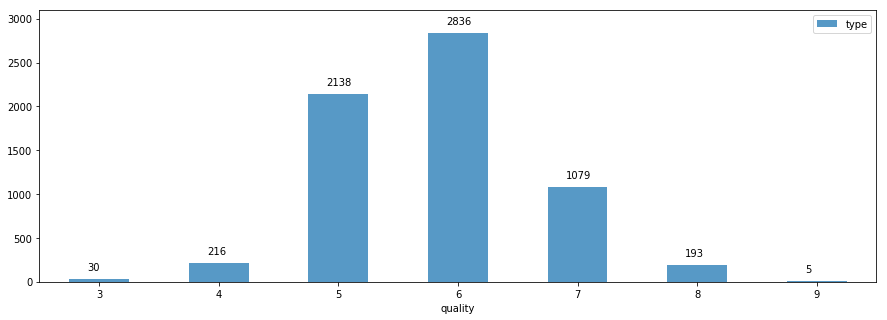

In [5]:
grouped_df = df.groupby('quality').agg({'type':'count'}).reset_index()

# plt.figure(figsize=(15,5))
ax = grouped_df.plot.bar(x='quality', figsize=(15,5), alpha=0.75, rot=0, ylim=(0,3100))
x_offset = -0.1
y_offset = 100
for p in ax.patches:
    b = p.get_bbox()
    val = "{}".format(int(b.y1 + b.y0))        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

### Explorando variáveis categóricas

O código abaixo mostra que a variável `type` contém apenas dois valores possíveis: _White_ e _Red_. É possível notar também que 75% dos exemplos são de vinhos branco e os demais de vinho tinto. 

In [6]:
df_grouped = df.groupby('type').agg({'quality': 'count'}).reset_index().rename(columns={"quality": 'type_count'})
df_grouped['type_perc'] = (df_grouped['type_count']*100/df_grouped['type_count'].sum())
df_grouped.head()

,type,type_count,type_perc
0,Red,1599,24.611359
1,White,4898,75.388641


### Explorando variáveis numéricas

O código abaixo apresenta um resumo das variáveis numéricas do dataset. É importante notar que elas não estão na mesma escala, como é o caso das variáveis `volatile_acidity`, que possui valores entre 0.08 e 1.5, e `total_sulfur_dioxide`, que possui valores entre 6.0 e 44.0. Outro ponto interessante a ser notado é que algumas variáveis parecem ter _outliers_, tais como `total_sulfur_dioxide` e `free_sulfur_dioxide`, cujos valores máximos são muito superiores ao percentil de 99% (foi feito o histograma dessas duas variávels a título de exemplo). 

Uma consequência interessante dessas observações é que teremos de fazer transformações nos dados para que estejam na mesma escala. Essa atividade será feita mais adiante na etapa de pré processamento dos dados. 

In [16]:
numeric_cols = ["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", 
                "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "ph", "sulphates"]

df[numeric_cols].describe(percentiles=[.25, .5, .75, .99])

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,1.710882,3.218501,0.531268
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,7.636088,0.160787,0.148806
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000
99%,12.000000,0.880000,0.740000,18.200000,0.186160,77.000000,238.000000,10.008000,3.640000,0.990000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,103.898000,4.010000,2.000000


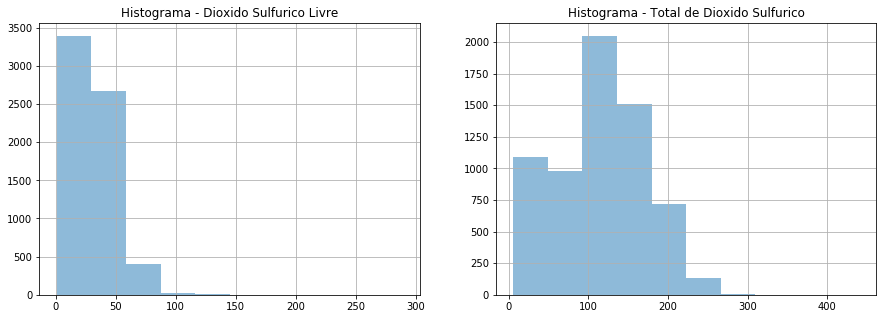

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

df['free_sulfur_dioxide'].hist(alpha=.5, ax=axes[0])
axes[0].set_title('Histograma - Dioxido Sulfurico Livre')
df['total_sulfur_dioxide'].hist(alpha=.5, ax=axes[1])
axes[1].set_title('Histograma - Total de Dioxido Sulfurico')
plt.show()

### O caso da variável alcohol

Como citado anteriormente, a variável `alcohol` foi identificada pelo Pandas como `object` porém ela deveria ser `float64` (numérica). O código abaixo mostra que existem alguns valores anômalos no dataset, provavelmente advindos de medições inadequadas. Também é possível notar que os exemplos com dados equivocados correspondem a apenas 0,6% do todo. Para lidar com essa situação, iremos remover as linhas em que `alcohol_numeric == NaN`. 

In [28]:
df['alcohol_numeric'] = pd.to_numeric(df['alcohol'], errors='coerce')

In [29]:
df.loc[df['alcohol_numeric'].isnull(), ['alcohol', 'alcohol_numeric']].head(10)

,alcohol,alcohol_numeric
4315,128.933.333.333.333,NaN
4319,128.933.333.333.333,NaN
4323,114.666.666.666.667,NaN
4341,100.333.333.333.333,NaN
4353,114.333.333.333.333,NaN
4356,105.333.333.333.333,NaN
4358,953.333.333.333.333,NaN
4364,109.333.333.333.333,NaN
4369,109.333.333.333.333,NaN
4372,113.666.666.666.667,NaN


In [30]:
df.loc[df['alcohol_numeric'].notnull(), ['alcohol', 'alcohol_numeric']].head()

,alcohol,alcohol_numeric
0,8.8,8.8
1,9.5,9.5
2,10.1,10.1
3,9.9,9.9
4,9.9,9.9


In [31]:
errors_count = (df[df['alcohol_numeric'].isnull()].shape[0]*100)/df.shape[0]

print("Apenas {:2f}% das linhas contem dados inadequados de teor alcoolico".format(errors_count))

Apenas 0.615669% das linhas contem dados inadequados de teor alcoolico


In [44]:
df = df[df['alcohol_numeric'].notnull()]

## Pré processamento dos dados

Antes de seguir com a análise, vamos aplicar as tranformações 

## Relação entre as variáveis

Nesta seção vamos identificar como as variáveis preditoras se relacionam com a variável de destino. Para isso, vamos dividir a análise em duas partes: aplicaremos o teste Chi quadrado para a variável categórica `type` e aplicaremos a correlação de Pearson para as variáveis numéricas.

### Correlação para variáveis numéricas

**TODO -  explicar por que é usada correlação de pearson aqui**

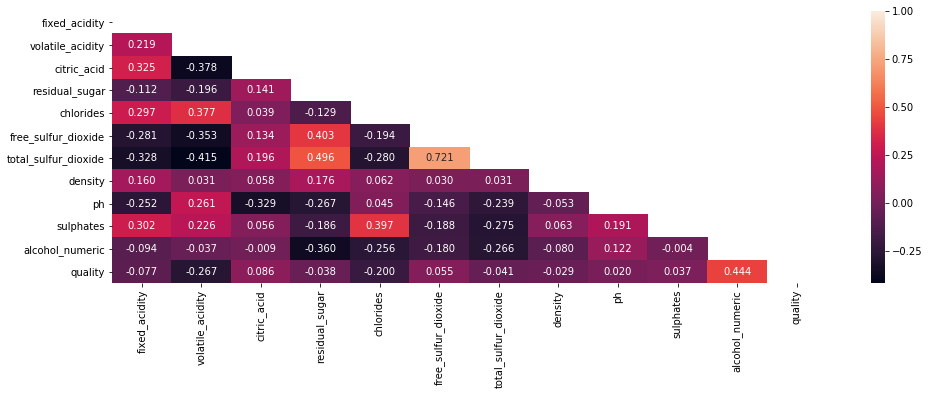

In [50]:
numeric_cols = ["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", 
                "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "ph", "sulphates", "alcohol_numeric"]
output_col = ["quality"]

plt.figure(figsize=(16,5))
corr = df[numeric_cols+output_col].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True, fmt= '.3f')
plt.show()

### Correlação para variáveis categóricas

**TODO - explicar por que é usado o teste do chi quadrado aqui**

Como pode ser visto no código abaixo, o p-value do teste é $8,66 times 10^{-23}$, o que significa que devemos rejeitar a hipótese nula de que a variável `type_encoded` é independente da variável `quality`. Isso é um indicativo de que devemos manter a variável `type_encoded` no modelo.

In [69]:
def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(chi2_contingency(ctsum.fillna(0)))

In [70]:
df['type_encoded'] = df['type'].apply(lambda x: 1 if x == "Red" else 2)

In [73]:
categorical_cols = ['type', 'quality']

chi2, p_value, dof, expected =  chisq_of_df_cols(df, 'type_encoded', 'quality')

print("p-value is: {}".format(p_value))

p-value is: 8.66434779598e-23


## Pré processamento dos dados

A partir das observações expostas na seção de análise exploratória dos dados, 

## Referências

[1] How to calculate Chi Square Test for Independence (two way) - https://www.youtube.com/watch?v=xEiQn6sGM20

[2] Feature Selection Methods https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/

https://sebastianraschka.com/Articles/2014_python_lda.html

https://stackabuse.com/implementing-lda-in-python-with-scikit-learn/

https://medium.com/journey-2-artificial-intelligence/lda-linear-discriminant-analysis-using-python-2155cf5b6398

In [36]:
%%html

<style>
span.text-red {
    color: red;
}

span.text-strike {
    text-decoration: line-through;
}

</style>

* Segmentar o dataset em treino e teste proporcionalmente às classes (strateified train_test_split)
* Fazer limpeza na variável `alcohol` (tem uns valores inputados de forma esquisita), a ideia é remover eles
* Fazer testes estatísticos para cada uma das variáveis preditoras
* Fazer exploração do domínio de valores de cada variável
* Explicar qual a função de custo (qual selecionei e por quê)
* Testar diferentes algoritmos e discorrer sobre o porquê da escolha
* Qual métrica de validação do modelo e por quê
* Remover outliers das variáveis de entrada
* Transformar variáveis categóricas em números
* Usar técnica diferenciada para variáveis categóricas (encontrada no desafio do LuizaLabs)
* <span class="text-red">Teste</span>

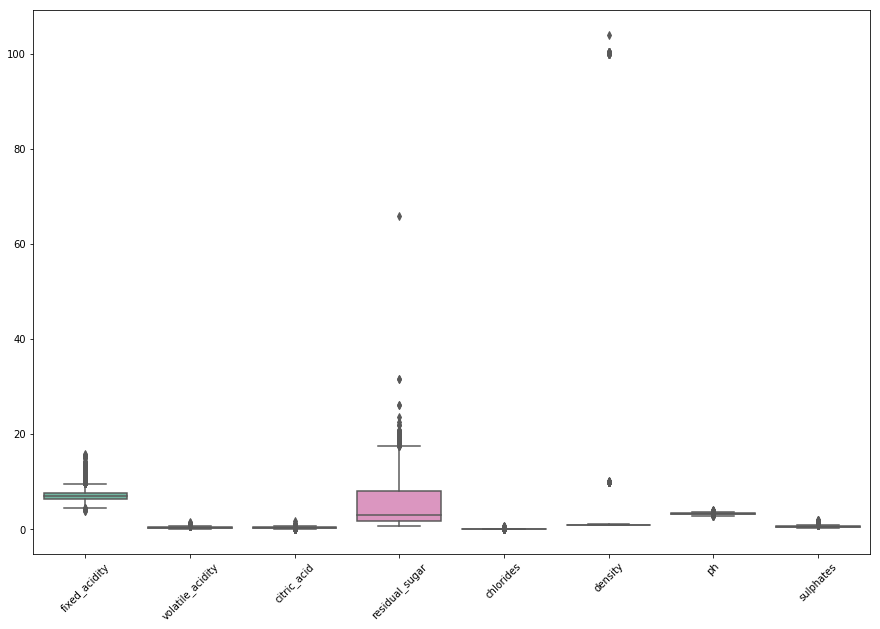

In [21]:
small_numeric_cols = [i for i in numeric_cols if i not in ["free_sulfur_dioxide", "total_sulfur_dioxide"]]
plt.figure(figsize=(15,10))
ax = sns.boxplot(data=df[small_numeric_cols], palette="Set2")
plt.xticks(rotation=45)
plt.show()

In [18]:
df[df['total_sulfur_dioxide'] == 440.0]

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
4745,White,6.1,0.26,0.25,2.9,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3


In [14]:
pd.to_numeric(df['alcohol'], errors='coerce')

0        8.8
1        9.5
2       10.1
3        9.9
4        9.9
5       10.1
6        9.6
7        8.8
8        9.5
9       11.0
10      12.0
11       9.7
12      10.8
13      12.4
14       9.7
15      11.4
16       9.6
17      12.8
18      11.3
19       9.5
20      12.8
21      11.0
22      10.5
23       9.3
24      10.0
25      10.4
26      10.0
27      10.5
28      11.6
29      12.3
        ... 
6467    11.5
6468    12.4
6469    11.1
6470     9.5
6471    12.5
6472    10.5
6473    11.8
6474    10.8
6475    11.9
6476    11.3
6477    11.3
6478    11.9
6479    11.3
6480    11.9
6481     9.8
6482    11.6
6483    11.5
6484    11.4
6485    10.9
6486    12.8
6487     9.2
6488    11.6
6489    11.6
6490    11.0
6491     9.5
6492    10.5
6493    11.2
6494    11.0
6495    10.2
6496    11.0
Name: alcohol, Length: 6497, dtype: float64